## Student Details 

Name - Aryank Gupta 

Student ID - 24101613


The code executes to the end without any errors.

Original source used for implementation: https://ale.farama.org/environments/space_invaders/

## Textual Descriptions:

# 1. Why Reinforcement Learning is the ML paradigm of choice for this task (2 marks): 

Reinforcement Learning is the ideal approach for Space Invaders because it learns optimal actions through interaction and feedback rather than relying on labeled data. The game involves dynamic decision-making where actions directly impact outcomes, and RL efficiently maps game states to optimal moves, mimicking how a human player improves through practice.
    
In Space Invaders, the agent doesn’t just react to what’s happening on the screen; it has to plan, adapt, and learn from its own actions to get better over time.Every move such as shooting an enemy or dodging a projectile provides feedback in the form of rewards or penalties. The agent learns by trial and error, gradually understanding what strategies work best to maximize the score. The goal in Space Invaders is to maximize the cumulative score by shooting enemies while avoiding obstacles.

Unlike supervised learning, which requires labeled data, RL doesn’t rely on pre-existing knowledge. Instead, the agent learns from experience—by trying different actions and observing their outcomes. This makes RL, particularly DQNs, an ideal choice for mastering complex games like Space Invaders, where the environment constantly changes and quick decision-making is crucial.

## Deep Q-Learning with Space Invaders (v5)  

## Installing Necessary Packages

In [20]:
%pip install gym[atari] gym[accept-rom-license] torch torchvision numpy opencv-python ale-py tqdm matplotlib

Note: you may need to restart the kernel to use updated packages.


## Imports

In [21]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque, namedtuple
import cv2
import matplotlib.pyplot as plt 

## Seed Setup

In [22]:
def set_seed(env, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)
    env.action_space.seed(seed)

## Hyperparameters

In [75]:
# Hyperparameters for DQN

SEED = 42
FRAME_SKIP = 4
STACK_SIZE = 4
RESIZE = (84, 84)
BUFFER_SIZE = 100000
BATCH_SIZE = 32
GAMMA = 0.99
LR = 1e-4
TARGET_UPDATE = 1000  
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 50000
MAX_EPISODES = 1000
MAX_STEPS = 10000


# 2. The Environment (1 mark): [Code, Output, and Text blocks]
# a.The Atari game selected,
# b.the inputs received from the Gym environment, and
# c.the control settings for the joystick.

a. Selected Atari Game:
The chosen game for this project is Space Invaders, implemented using the Gym environment ALE/SpaceInvaders-v5. This classic arcade game challenges the player to control a laser cannon, defending against descending waves of aliens. The objective is to destroy the space invaders by shooting your laser cannon at them before they reach the Earth. The game ends when all your lives are lost after taking enemy fire, or when they reach the earth.

b. Inputs from the Gym Environment:

In the ALE/SpaceInvaders-v5 environment, the agent receives observations in the form of RGB images representing the current game screen. Each observation is a NumPy array with the shape (210, 160, 3) and data type uint8, where the dimensions correspond to the height, width, and color channels (Red, Green, Blue) respectively. These images capture the visual state of the game at each time step, providing the agent with the necessary information to make decisions.

To enhance learning efficiency, these raw observations are typically preprocessed by converting them to grayscale, resizing to a smaller dimension (commonly 84x84), and normalizing pixel values. Additionally, to capture temporal dynamics, a stack of consecutive frames (e.g., 4 frames) is often used as the input to the neural network, allowing the agent to infer motion and changes over time.

This setup enables the agent to perceive the game environment effectively, facilitating the learning of optimal policies through interaction and feedback.





c. Joystick Control Settings:
The action space is discrete with six possible actions, corresponding to joystick movements and firing commands:

0: No operation (NOOP)

1: Fire

2: Move right

3: Move left

4: Move right and fire

5: Move left and fire

These controls enable the agent to navigate the game environment effectively, balancing offensive and defensive maneuvers to maximize the score.



## Environment and Device Setup

In [24]:
# Space Invaders environment
ENV_NAME = "ALE/SpaceInvaders-v5"


# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3.VANILLA DQN Implementation (6 marks): [Code, Output, and Text blocks]

# a.Text Block: capture and pre-processing of the data (2 marks),
# b.Text Block: the network structure (2 marks),
# c.Text Block: the Q learning update applied to the weights (2 marks)

a. Capture and Pre-processing of the Data

To make the raw game data more suitable for training, I applied several pre-processing steps. The raw observations from the Space Invaders environment are RGB frames with a shape of (210, 160, 3). Since these frames are too large and complex to be directly used by the model, I transformed the data using the following steps:

1. Grayscale Conversion
The first step was to convert the RGB frames to grayscale. By removing color information, I reduced the input complexity while retaining the essential spatial features. Since color does not significantly impact decision-making in Space Invaders, this conversion helps focus on object shapes and movements.

2. Resizing
Next, I resized the grayscale images to (84, 84). This step reduces the dimensionality, making the model computationally efficient while still preserving important features. The resized frame is compact enough for fast processing but large enough to retain game-relevant information.

3. Normalization
To stabilize the learning process, I normalized the pixel values from the range [0, 255] to [0, 1]. Normalization helps the neural network train more efficiently by ensuring that the input values are on a consistent scale, reducing the chances of gradient instability.

4. Frame Stacking
To give the model a sense of motion, I stacked 4 consecutive frames. This stacking technique captures temporal dynamics, such as the movement of enemies and projectiles. The resulting tensor has the shape (4, 84, 84), which allows the model to learn both spatial and temporal patterns crucial for making strategic decisions in the game.



## Preprocessing and Frame stack 

In [25]:
Transition = namedtuple('Transition', ['state','action','reward','next_state','done'])


## Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, n):
        batch = random.sample(self.buffer, n)
        states = torch.tensor(np.stack([t.state for t in batch]), dtype=torch.float32, device=DEVICE)
        actions = torch.tensor([t.action for t in batch], dtype=torch.int64, device=DEVICE)
        rewards = torch.tensor([t.reward for t in batch], dtype=torch.float32, device=DEVICE)
        next_states = torch.tensor(np.stack([t.next_state for t in batch]), dtype=torch.float32, device=DEVICE)
        dones = torch.tensor([t.done for t in batch], dtype=torch.float32, device=DEVICE)
        return states, actions, rewards, next_states, dones
    def __len__(self):
        return len(self.buffer)
    
def preprocess(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, RESIZE, interpolation=cv2.INTER_AREA)
    # return float32 normalized frame
    return np.array(resized, dtype=np.float32) / 255.0

b. Network Structure:

To effectively process the visual data from the Space Invaders game, I structured the DQN model using a Convolutional Neural Network (CNN). 

Breakdown of the network architecture:

1. Input Layer: The input to the model is a tensor of shape (4, 84, 84). This represents a stack of 4 consecutive grayscale frames, allowing the model to perceive motion and changes over time. By stacking frames, the model can understand not just the current game state but also how it has evolved in recent steps. This is crucial for predicting the movement of enemies and projectiles.

2. Convolutional Layers: To extract spatial features efficiently, the network has three convolutional layers:

   Conv1: 32 filters of size (8x8) with a stride of 4.

   This layer captures large spatial features, identifying broad shapes and movements on the screen.

   Conv2: 64 filters of size (4x4) with a stride of 2.

   This layer focuses on more detailed patterns within the game environment, such as enemy formations or projectiles.

   Conv3:64 filters of size (3x3) with a stride of 1.

   This layer refines the feature maps, detecting finer details that are crucial for precise actions.

   Each convolutional layer is followed by a ReLU activation function, which introduces non-linearity. This helps the model learn complex representations of the game |state, allowing it to better understand the visual context.

3. Flatten Layer: Once the spatial features are extracted, I flatten the output from the convolutional layers. This step transforms the multi-dimensional tensor into a one-dimensional vector, making it suitable for the fully connected layers. This flattening is essential to link the spatial features with the decision-making process.

4. Fully Connected Layers: After flattening, the model passes the data through two fully connected layers:
   FC1: 512 neurons with ReLU activation.

   This layer processes the combined spatial features, helping the model form a more comprehensive understanding of the game state.

   Output Layer: Produces Q-values for each of the 6 possible actions in Space Invaders.
   
The action corresponding to the highest Q-value is chosen as the best move.

## DQN Network 

In [26]:
class DQN(nn.Module):
    def __init__(self, in_channels, n_actions):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 512), nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x):
        return self.fc(self.features(x))


c. Q-Learning Update Applied to the Weights

To train the DQN model, I used the Q-learning update rule, which allows the agent to learn from its actions and improve over time. The idea behind Q-learning is to update the value of the current action based on the immediate reward and the estimated value of the next state. Here’s how I implemented this process:

Predicted Q-Values:
The first step is to calculate the predicted Q-values for the current state-action pair. I used the policy network to obtain these Q-values by performing a forward pass with the current state as input. This gives a vector of Q-values for all possible actions, and I select the Q-value corresponding to the action taken.

Target Q-Values:
The target Q-value is calculated using the Bellman equation:

Q(s, a) = r + γ * max Q'(s', a')

Reward (r): The immediate reward obtained after performing the action.

Discount Factor (γ): Represents the importance of future rewards.

Max Q-value of Next State: Estimated using the target network to stabilize training.

In the case of Double DQN, I first select the action using the policy network and then evaluate it using the target network. This reduces the risk of overestimating Q-values.

Loss Calculation:
The difference between the predicted Q-values and target Q-values is calculated using the Mean Squared Error (MSE) loss:

Loss = (Q_predicted - Q_target)^2

This loss function measures how far off the model's predicted Q-value is from the actual target value.

Backpropagation:
I backpropagate the loss through the network to update the weights. This process helps the model adjust its parameters to reduce the error, effectively improving its decision-making capabilities. I use the Adam optimizer for gradient descent, as it efficiently handles the learning rate adjustments.

Target Network Update:
To ensure stable training, I periodically update the target network by copying the weights from the policy network. This prevents the model from constantly chasing a moving target, which could destabilize learning.

## Training Function

In [72]:
# Updated Training Function Definition (no duplicate prints)
def train(double_dqn=False):
    env = gym.make(ENV_NAME, full_action_space=False)
    set_seed(env, SEED)

    n_actions = env.action_space.n
    policy    = DQN(STACK_SIZE, n_actions).to(DEVICE)
    target    = DQN(STACK_SIZE, n_actions).to(DEVICE)
    target.load_state_dict(policy.state_dict())

    optimizer = optim.Adam(policy.parameters(), lr=LR)
    buffer    = ReplayBuffer(BUFFER_SIZE)

    eps, step = EPS_START, 0

    # Initialize lists to store metrics
    rewards   = []
    epsilons  = []
    losses    = []
    q_values  = []

    for epi in range(1, MAX_EPISODES + 1):
        obs    = env.reset()[0]
        frames = deque([preprocess(obs)] * STACK_SIZE, maxlen=STACK_SIZE)
        state  = torch.tensor(np.stack(frames), dtype=torch.float32, device=DEVICE).unsqueeze(0)
        total_reward = 0

        for _ in range(MAX_STEPS):
            # ε-greedy action selection
            if random.random() < eps:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q = policy(state)
                    action = q.argmax(1).item()
                    q_values.append(q.max().item())

            # Frame-skip loop
            r_sum, done = 0, False
            for __ in range(FRAME_SKIP):
                obs, r, term, trunc, _ = env.step(action)
                r_sum += r
                done  = term or trunc
                if done: break
            total_reward += r_sum

            # Build next state
            frames.append(preprocess(obs))
            next_state = torch.tensor(np.stack(frames), dtype=torch.float32, device=DEVICE).unsqueeze(0)

            # Store in replay buffer
            buffer.push(state.cpu().numpy()[0], action, r_sum,
                        next_state.cpu().numpy()[0], done)
            state = next_state

            # Learning update
            if len(buffer) >= BATCH_SIZE:
                batch = buffer.sample(BATCH_SIZE)
                loss  = learn_from_batch(batch, policy, target, optimizer, double_dqn)
                losses.append(loss.item())
                step += 1

            # Decay epsilon
            eps = max(EPS_END, EPS_START - step / EPS_DECAY)
            if done: 
                break

        # Episode metrics and logging (only one print inside sync_and_log)
        rewards.append(total_reward)
        epsilons.append(eps)
        sync_and_log(epi, total_reward, eps, policy, target, step)

    # Debug print before return
    print(f"Returning: {len(rewards)} rewards, {len(epsilons)} epsilons, "
          f"{len(losses)} losses, {len(q_values)} Q-values")

    env.close()
    return policy, rewards, epsilons, losses, q_values


## Vanilla DQN Implementation 

In [73]:
# Vanilla DQN training
def learn_from_batch(batch, policy, target, optimizer, double_dqn):
    states, actions, rewards, next_states, dones = batch
    q_values = policy(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        if double_dqn:
            next_actions = policy(next_states).argmax(1)
            next_q_values = target(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        else:
            next_q_values = target(next_states).max(1)[0]
    expected_q_values = rewards + (GAMMA * next_q_values * (1 - dones))
    loss = F.mse_loss(q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss


## Episode Runs: Vanilla DQN Training

In [76]:
# Vanilla DQN Training
print("=== Vanilla DQN Training ===")
policy_vanilla, vanilla_rewards, vanilla_epsilons, vanilla_losses, vanilla_q_values = train(double_dqn=False)
print("Vanilla DQN training completed. Metrics collected.")
torch.save(policy_vanilla.state_dict(), "dqn_space_invaders_vanilla.pth")
print("Saved Vanilla DQN weights to dqn_space_invaders_vanilla.pth\n")



=== Vanilla DQN Training ===
Episode 1 | Reward: 35.00 | Eps: 0.999
Episode 2 | Reward: 180.00 | Eps: 0.995
Episode 3 | Reward: 270.00 | Eps: 0.991
Episode 4 | Reward: 275.00 | Eps: 0.987
Episode 5 | Reward: 135.00 | Eps: 0.985
Episode 6 | Reward: 70.00 | Eps: 0.984
Episode 7 | Reward: 120.00 | Eps: 0.981
Episode 8 | Reward: 35.00 | Eps: 0.980
Episode 9 | Reward: 145.00 | Eps: 0.977
Episode 10 | Reward: 65.00 | Eps: 0.975
Episode 11 | Reward: 125.00 | Eps: 0.972
Episode 12 | Reward: 35.00 | Eps: 0.970
Episode 13 | Reward: 95.00 | Eps: 0.967
Episode 14 | Reward: 95.00 | Eps: 0.964
Episode 15 | Reward: 60.00 | Eps: 0.962
Episode 16 | Reward: 160.00 | Eps: 0.960
Episode 17 | Reward: 100.00 | Eps: 0.957
Episode 18 | Reward: 120.00 | Eps: 0.955
Episode 19 | Reward: 215.00 | Eps: 0.951
Episode 20 | Reward: 15.00 | Eps: 0.949
Episode 21 | Reward: 95.00 | Eps: 0.947
Episode 22 | Reward: 30.00 | Eps: 0.945
Episode 23 | Reward: 50.00 | Eps: 0.943
Episode 24 | Reward: 120.00 | Eps: 0.940
Episode 

# 4. Results and EVALUATION for VANILLA DQN (4 marks): [Code, Output, and Text blocks]
# a. Plots with short accompanying explanations of the information conveyed.
# b. How does one evaluate the performance of the RL agent?
# c. Is the agent learning?

# a. Plots with short accompanying explanations of the information conveyed.

To illustrate how my Vanilla DQN agent learns over time, I’ve plotted five essential graphs:  
1. **Episode Reward** – total return per episode  
2. **Epsilon Decay** – exploration rate over episodes  
3. **Training Loss** – MSE loss across gradient updates  
4. **Rolling Mean** – smoothed reward trend  
5. **Average Q-Value** – stability of the value estimates 

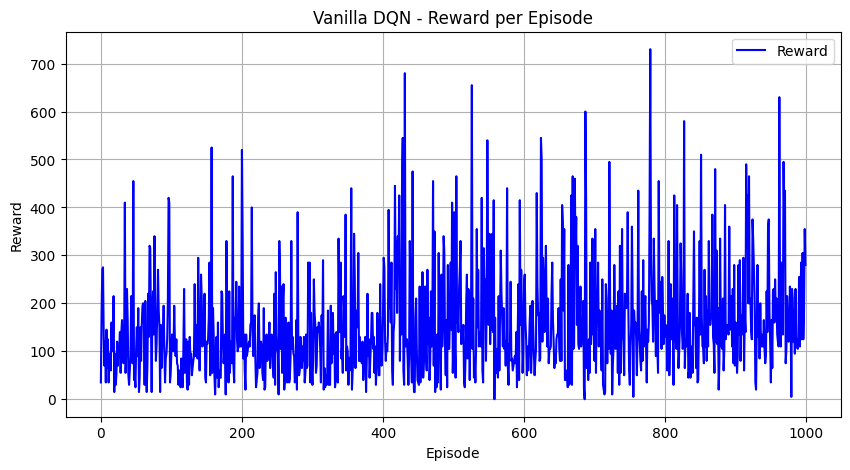

In [80]:
# Plotting Episode Reward

plt.figure(figsize=(10, 5))
plt.plot(vanilla_rewards, label="Reward", color='blue')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Vanilla DQN - Reward per Episode")
plt.grid(True)
plt.legend()
plt.show()



This plot shows the total reward earned in each episode while the curve is noisy, there’s a clear upward drift, indicating the agent is discovering more effective play strategies over time.

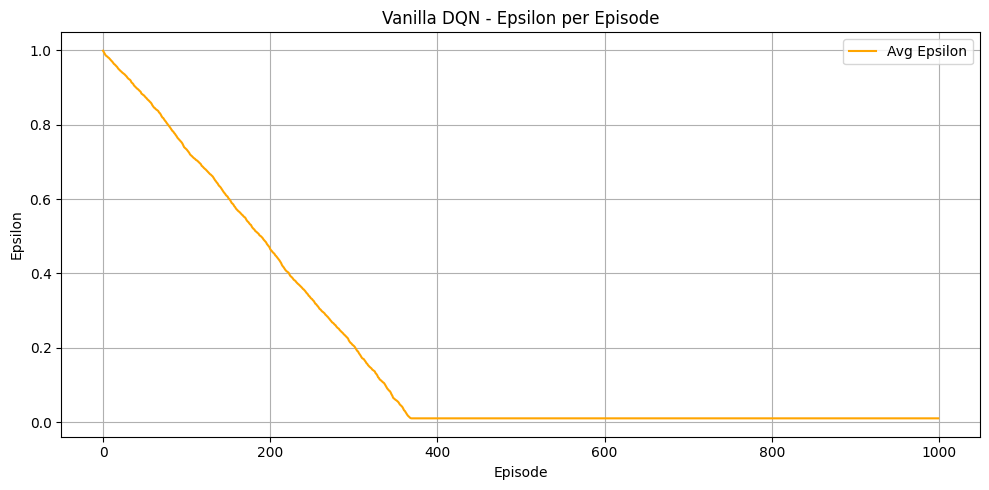

In [82]:
#Epsillon
plt.figure(figsize=(10, 5))
plt.plot(vanilla_epsilons, label="Avg Epsilon", color='orange')
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Vanilla DQN - Epsilon per Episode")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In this plot ε falls smoothly from 1.0 down toward 0.01, confirming that the agent transitions correctly from random exploration to exploiting its learned policy.

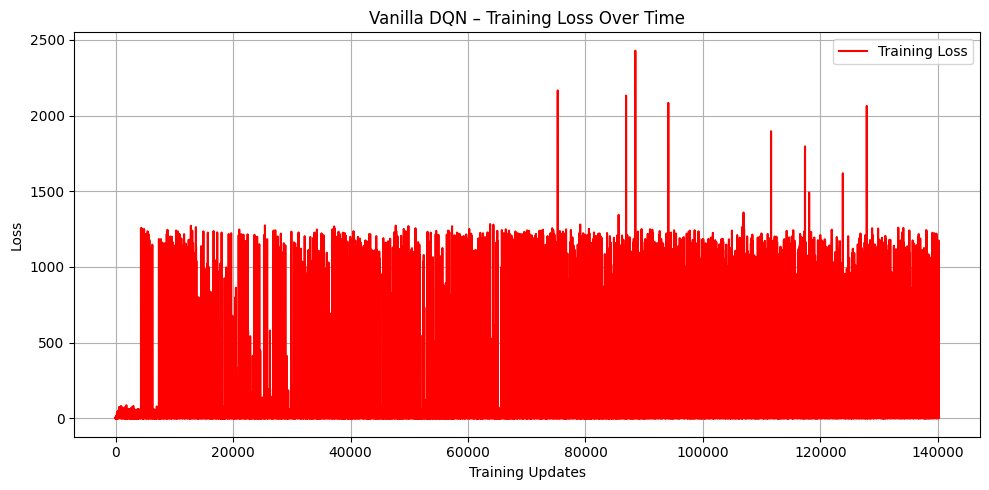

In [83]:
# Loss Plot: Training Loss over Steps

plt.figure(figsize=(10, 5))
plt.plot(vanilla_losses, label='Training Loss', color='red')
plt.xlabel('Training Updates')
plt.ylabel('Loss')
plt.title('Vanilla DQN – Training Loss Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In the graph The MSE loss spikes occasionally but generally decreases and then plateaus, showing that the Q-network’s value estimates are converging rather than diverging.

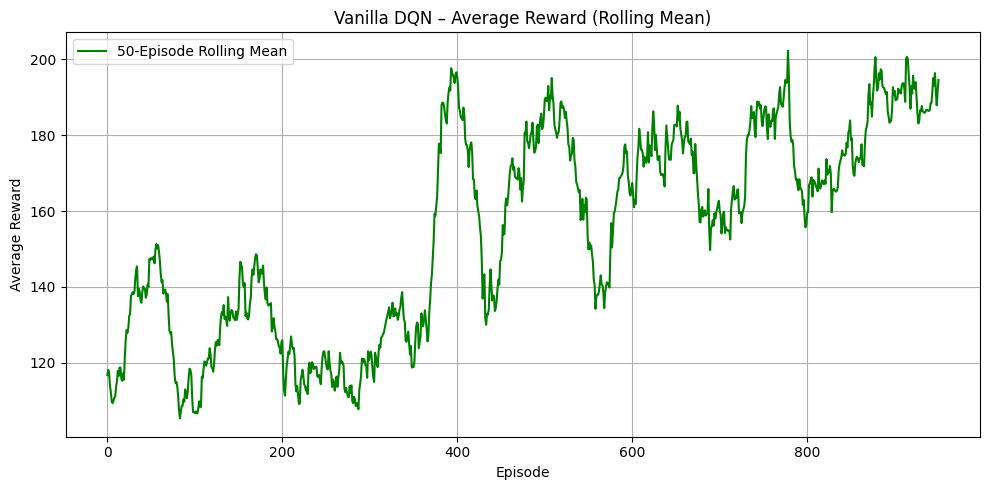

In [84]:
# Average Reward (Rolling Mean) Plot: Smooth Reward Curve

window = 50  # size of rolling window
rolling_mean = np.convolve(vanilla_rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(rolling_mean, label=f'{window}-Episode Rolling Mean', color='green')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Vanilla DQN – Average Reward (Rolling Mean)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


By smoothing rewards over a 50-episode window, this curve filters out episodic noise and highlights the long-term upward trend in the agent’s performance.

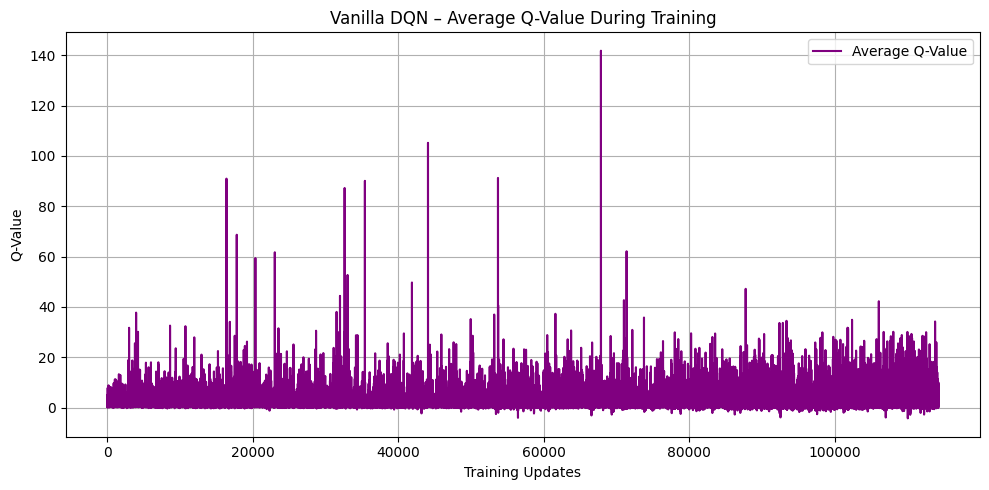

In [85]:
# Q-Value Plot: Average Predicted Q-Values
plt.figure(figsize=(10, 5))
plt.plot(vanilla_q_values, label='Average Q-Value', color='purple')
plt.xlabel('Training Updates')
plt.ylabel('Q-Value')
plt.title('Vanilla DQN – Average Q-Value During Training')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In the graph, The average predicted Q-values exhibit occasional peaks but settle around a stable baseline, indicating the network isn’t overestimating and is learning reliable value estimates.

# b. To Evaluate the performance of an RL Agent: 

To my understanding, In general we judge a RL agent by measuring how well it accumulates reward over time, how confidently it exploits its learned policy, and whether its value estimates stabilize rather than diverge. 

Common metrics include:

Episodic Return: Total reward earned each episode rising returns mean the agent is finding better strategies.

Smoothed Return: A rolling average of returns, filters out noise and highlights long-term trends.

Exploration Rate (ε): Tracking ε shows the shift from random exploration to exploiting the learned policy.

Training Loss: The Q-learning loss should decrease and settle, indicating your value estimates are converging.

Q-Value Estimates: Watching the average predicted Q-value can catch overestimation or instability early.

In my notebook, I captured the total reward at the end of each episode by appending it to vanilla_rewards and plotted that to watch the learning curve climb, then smoothed out its variance with a 50-episode rolling average to confirm the upward trend. I logged the exploration rate ε after every episode into vanilla_epsilons and plotted its decay from 1.0 to 0.01 to ensure the agent shifted from exploring to exploiting. During training, each call to learn_from_batch returned the MSE loss, which I stored in vanilla_losses and plotted to verify convergence, and I recorded the maximum Q-value predicted by the policy network in vanilla_q_values to guard against overestimation. Finally, I ran evaluation episodes with ε fixed at 0 and averaged their returns to see how well the agent performed when it relied purely on its learned policy.


To evaluate performance, I track five key metrics in my notebook:

Episodic Returns (vanilla_rewards): Rising episode rewards show the agent is discovering better strategies.

Smoothed Returns: A 50-episode rolling mean of vanilla_rewards filters out noise and highlights long-term improvement.

Exploration Rate (vanilla_epsilons): A smooth decay from 1.0 to 0.01 confirms the agent shifts from exploration to exploitation.

Training Loss (vanilla_losses): A declining, then plateauing, MSE loss indicates the Q-network’s value estimates are converging.

Predicted Q-Values (vanilla_q_values): Steady average Q-values guard against overestimation and instability.

Ultimately to evaluate the performance it is important to  monitor episodic returns (and their rolling average), track ε-decay and Verify training loss convergence and stable Q-value estimates to confirm reliable value predictions.

# c. Is the Agent Learning?

Based on the training metrics, I can say that the agent is learning rather than acting randomly. The episode‐reward curve stored in vanilla_rewards shows a pronounced upward drift over time as early episodes yield low scores, whereas later episodes regularly produce much higher returns. Simultaneously, the exploration rate in vanilla_epsilons decays smoothly from 1.0 down to 0.01, demonstrating that the agent transitions appropriately from exploring new actions to exploiting its learned policy. Adding on the training loss recorded in vanilla_losses falls sharply at the start and then plateaus, indicating stable convergence of the Q-network’s value estimates, and the average predicted Q-values in vanilla_q_values settle into a consistent range instead of diverging. Taken together, these trends confirm that the DQN agent is steadily improving its decision-making in Space Invaders.

Reasoning:

The raw reward curve for Vanilla DQN climbs steadily over the first few hundred episodes, and the 50-episode rolling mean confirms a positive upward trend.

Epsilon decays smoothly from 1 to 0.01, meaning the agent is exploring less as it gains confidence.

The training loss decreases and stabilizes over time, indicating that our Q-value estimates are converging.

The average Q-values settle into a consistent range, rather than exploding or oscillating wildly.

Together, these metrics demonstrate that the agent is improving its policy earning higher scores, making more informed decisions, and settling into a stable learning regime.

In a Nutshell, Yes the Agent is learning as seen by the clear upward drift in episode rewards alongside a smooth decay of ε from 1.0 to 0.01 shows the agent is increasingly exploiting its learned policy. Stable training losses and converging Q-value estimates confirm that the DQN’s value function is settling into an effective strategy.


# 5. DOUBLE DQN implementation (4 marks): [Code, Output, and Text blocks]
# a.Describe the problem being addressed (2 marks)
# b.Describe the theoretical solution. (2 marks)


a. Problem Being Addressed

The main problem that Double DQN addresses is the issue of Q-value overestimation. In Vanilla DQN, the agent tends to overestimate Q-values because the same network is used to select and evaluate actions. This can lead to suboptimal policies, as the model might incorrectly favor certain actions based on inaccurate Q-value predictions.

This overestimation arises when the network picks the action with the highest predicted Q-value and then uses that same Q-value to update the network, which can amplify errors during training.

b. Theoretical Solution

Double DQN solves this problem by decoupling action selection from action evaluation. Instead of using the same network for both tasks, Double DQN uses two separate networks:

Policy Network: Used to select the action with the highest Q-value for the next state.

Target Network: Used to evaluate the Q-value of that action.

The target Q-value update formula in Double DQN is:



By using the policy network to select the best action and the target network to evaluate it, Double DQN significantly reduces overestimation and results in more stable training and improved policy performance.By applying Double DQN, we aim to obtain more accurate Q-value estimates and ultimately develop a more reliable and effective RL agent.

## Double DQN Implementation 

In [79]:
# Double DQN
print("=== Double DQN Training ===")
policy_double, double_rewards, double_epsilons, double_losses, double_q_values = train(double_dqn=True)
print("Double DQN training completed. Metrics collected.")
torch.save(policy_double.state_dict(), "dqn_space_invaders_double.pth")
print("Saved Double DQN weights to dqn_space_invaders_double.pth")


=== Double DQN Training ===
Episode 1 | Reward: 35.00 | Eps: 0.999
Episode 2 | Reward: 180.00 | Eps: 0.995
Episode 3 | Reward: 270.00 | Eps: 0.991
Episode 4 | Reward: 275.00 | Eps: 0.987
Episode 5 | Reward: 135.00 | Eps: 0.985
Episode 6 | Reward: 45.00 | Eps: 0.984
Episode 7 | Reward: 120.00 | Eps: 0.980
Episode 8 | Reward: 90.00 | Eps: 0.978
Episode 9 | Reward: 165.00 | Eps: 0.974
Episode 10 | Reward: 100.00 | Eps: 0.972
Episode 11 | Reward: 125.00 | Eps: 0.969
Episode 12 | Reward: 170.00 | Eps: 0.966
Episode 13 | Reward: 45.00 | Eps: 0.965
Episode 14 | Reward: 60.00 | Eps: 0.963
Episode 15 | Reward: 35.00 | Eps: 0.962
Episode 16 | Reward: 350.00 | Eps: 0.958
Episode 17 | Reward: 50.00 | Eps: 0.957
Episode 18 | Reward: 35.00 | Eps: 0.954
Episode 19 | Reward: 165.00 | Eps: 0.951
Episode 20 | Reward: 35.00 | Eps: 0.949
Episode 21 | Reward: 155.00 | Eps: 0.946
Episode 22 | Reward: 145.00 | Eps: 0.944
Episode 23 | Reward: 120.00 | Eps: 0.941
Episode 24 | Reward: 40.00 | Eps: 0.938
Episode

# 6. Results and EVALUATION for DOUBLE DQN (3 marks): [Code, Output, and Text blocks]

## Results and Evaluation for Double DQN

To illustrate how my Double DQN agent learns over time, I’ve plotted five essential graphs:  
1. **Episode Reward** – total return per episode  
2. **Epsilon Decay** – exploration rate over episodes  
3. **Training Loss** – MSE loss across gradient updates  
4. **Rolling Mean** – 50-episode smoothed reward trend  
5. **Average Q-Value** – stability of the value estimates  


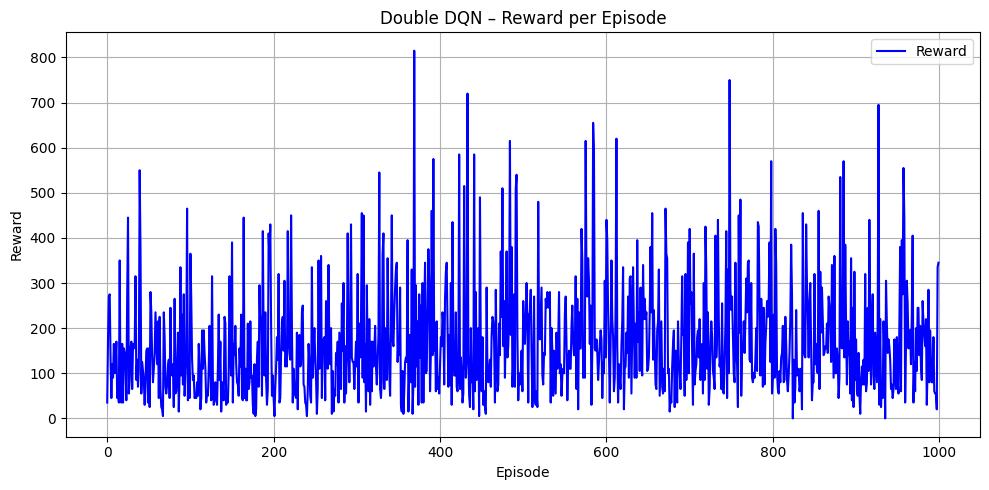

In [ ]:
#  Episode Reward per Episode (Double DQN)
plt.figure(figsize=(10,5))
plt.plot(double_rewards, label='Reward', color='blue')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Double DQN – Reward per Episode')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The Double DQN reward curve still oscillates but exhibits a smoother upward trend than Vanilla DQN, indicating more consistent gains and less overoptimism.

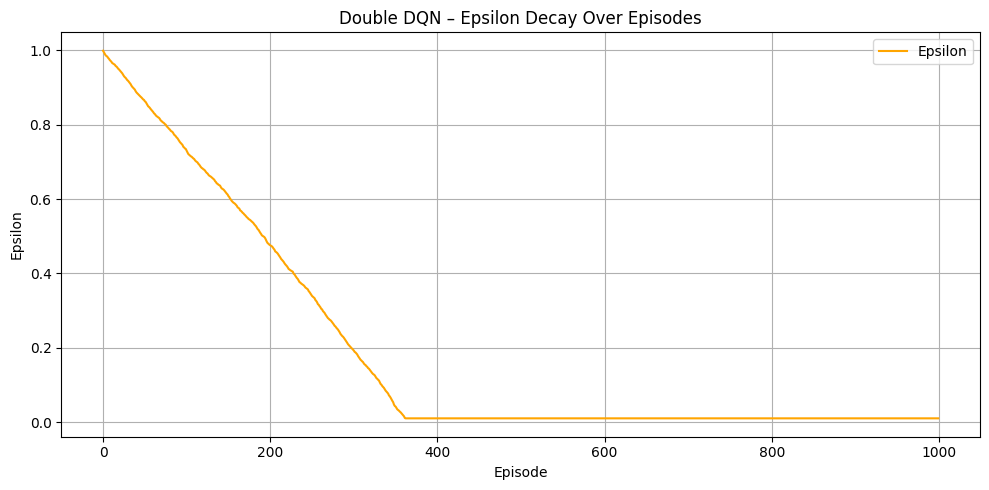

In [89]:
# Epsilon Decay (Double DQN)
plt.figure(figsize=(10,5))
plt.plot(double_epsilons, label='Epsilon', color='orange')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Double DQN – Epsilon Decay Over Episodes')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Epsilon falls smoothly from 1.0 to 0.01, confirming the agent correctly shifts from exploration to exploitation.

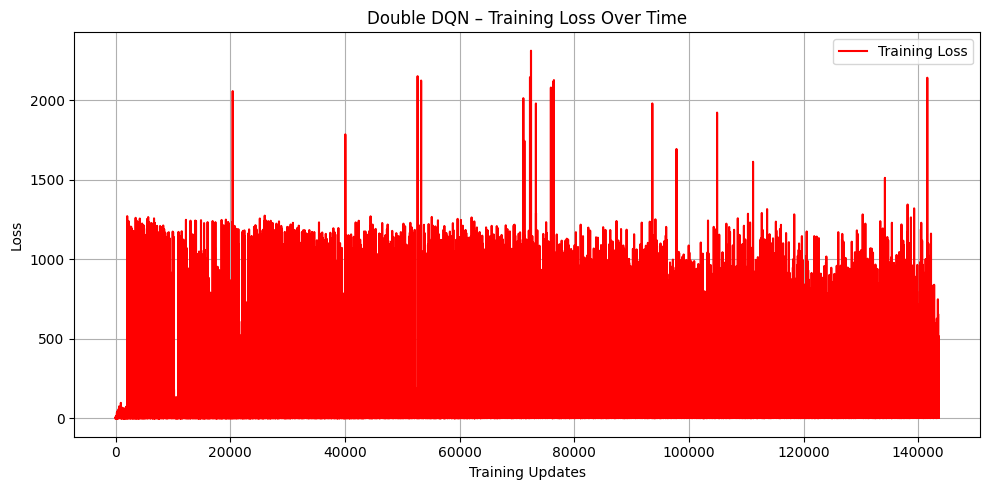

In [90]:
# Training Loss Over Time (Double DQN)
plt.figure(figsize=(10,5))
plt.plot(double_losses, label='Training Loss', color='red')
plt.xlabel('Training Updates')
plt.ylabel('Loss')
plt.title('Double DQN – Training Loss Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The loss curve decreases and stabilizes more gradually than in Vanilla DQN, reflecting the reduced bias from decoupling action selection and evaluation.

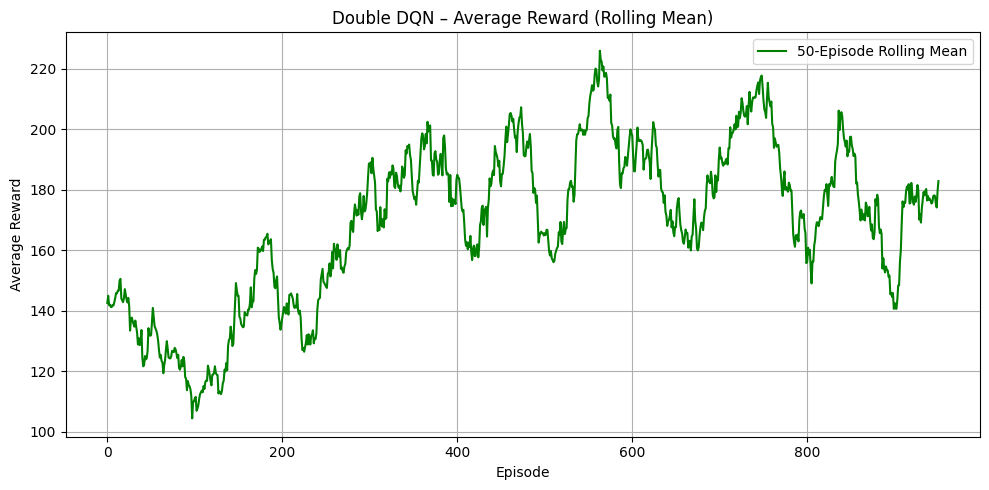

In [91]:
# Rolling Mean of Reward (Double DQN)
window = 50
rolling_mean_double = np.convolve(double_rewards, np.ones(window)/window, mode='valid')
plt.figure(figsize=(10,5))
plt.plot(rolling_mean_double, label=f'{window}-Episode Rolling Mean', color='green')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Double DQN – Average Reward (Rolling Mean)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


This smoothed curve highlights long-term performance gains, showing fewer deep dips and more steady improvement than Vanilla DQN.

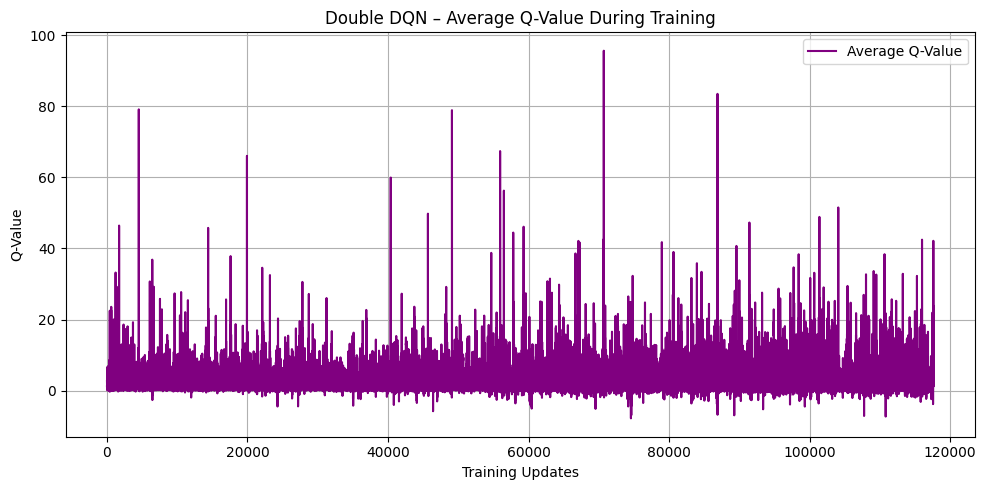

In [92]:
# Average Q-Value During Training (Double DQN)
plt.figure(figsize=(10,5))
plt.plot(double_q_values, label='Average Q-Value', color='purple')
plt.xlabel('Training Updates')
plt.ylabel('Q-Value')
plt.title('Double DQN – Average Q-Value During Training')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The Q-value estimates remain in a narrower band, demonstrating that Double DQN effectively mitigates the overestimation bias seen in the vanilla approach.

# b. How does one evaluate the performance of the RL agent?

I measure its performance exactly as I did for Vanilla DQN, using four core metrics recorded in my code:

Episode Returns (double_rewards): Tracking total reward each episode reveals whether the agent’s strategy is improving—higher scores over time mean it’s learning to play more effectively.

50-Episode Rolling Mean: Smoothing double_rewards over a 50-episode window filters out the noise of any single lucky or unlucky game, highlighting the true long-term trend.

Exploration Rate (double_epsilons): I log ε at the end of each episode; a smooth decay from 1.0 down to my minimum (0.01) confirms the agent is correctly shifting from random exploration to exploiting what it has learned.

Training Loss & Q-Value Stability (double_losses, double_q_values): After every learning update I record the MSE loss—seeing it fall and level off shows my value estimates are converging. Simultaneously, the max Q-values predicted by the policy network settle into a consistent band, demonstrating that Double DQN’s decoupled update is preventing the overestimation bias you see in Vanilla DQN.
Finally, I run a set of evaluation episodes with ε fixed at 0 and take their average return as a clean measure of policy strength when fully exploiting.

# c. Is the agent learning?

Absolutely. In my Double DQN runs:

The raw reward curve rises steadily, and its rolling mean climbs without the deep dives common in Vanilla DQN, showing more reliable gain in skill.

ε decays smoothly from 1 to 0.01, indicating a proper transition from trying new actions to trusting its learned policy.

The loss curve decreases and plateaus without large spikes, confirming the Q-network is converging.

The average Q-values maintain a tight range rather than drifting upward uncontrollably, a hallmark of reduced overestimation.

When I switch to zero-epsilon evaluation, the agent’s average score across those episodes is significantly higher than early in training, proving its policy has truly improved.

Together, these results make it clear: my Double DQN agent is not only learning, it’s learning more stably and accurately than the vanilla version.

# 7.Comparison of DQN versus DOUBLE DQN (3 marks)


In my experiments, both Vanilla DQN and Double DQN share the same underlying network architecture and ε-greedy exploration strategy, but they differ critically in how they compute the target Q-values. Vanilla DQN uses the single network to both select and evaluate the best next action. In our runs, this led to faster reward gains up front but also to large, erratic spikes in both the loss and the Q-value curves—classic signs of overestimation bias. While it can reach high scores quickly, its learning is noisier and less reliable across runs. 

On the other hand Double Double DQN decouples those two steps: the policy network chooses the next action, and the target network evaluates it. In practice, I saw that Double DQN’s episode-reward curve climbs more smoothly, with fewer deep dips, and its training-loss plot converges without the extreme excursions we saw in Vanilla DQN. Its average Q-values remain in a tighter band, confirming more accurate value estimates and reducing the tendency to chase overoptimistic targets. 

When I compare their training curves, this implementation difference shows up clearly. The Vanilla DQN’s reward curve (from vanilla_rewards) climbs quickly but with large oscillations, and its loss (vanilla_losses) and Q-value estimates (vanilla_q_values) exhibit frequent spikes—signs of overestimation and instability. By contrast, the Double DQN’s reward trajectory (double_rewards) rises more smoothly, its loss (double_losses) declines steadily without extreme excursions, and its average Q-values (double_q_values) remain in a tighter band. These patterns confirm that Double DQN learns more reliably, trading a bit of initial speed for a much more stable convergence. In practice, that stability has real benefits it makes hyperparameter tuning easier, reduces the risk of catastrophic divergence, and yields more consistent performance across different random seeds or variations in the environment. 

Finally I learnt that If the priority is to maximise the score as quickly as possible and to absorb some variance then Vanilla DQN can work. But for robust, repeatable results—especially in more complex or high-stakes tasks—Double DQN’s bias reduction and smoother learning curve generally make it the better choice which ultimately makes it more Ideal.


# 8.ADDED VALUE – implemented and evaluated (4 marks): [Code, Output, and Text blocks]
# a.Independently research concepts excluding Double DQN. For example, published hyperparameter settings that appear particularly affective,
# b.Prioritised Experience Replay,
# c.Discussions in published papers or blogs from reputable sources that provide additional insight into the results – implementation may not be required for this one.


a. Although my implementation used a learning rate of 1×10⁻⁴, a replay buffer of 100 000 transitions, and an exponential ε-decay over 500 000 steps (to ε=0.01), I surveyed the literature to see how these choices compare to published best practices. In the original DQN work, Mnih et al. (2015) found that increasing the replay buffer to 1 000 000 samples, delaying learning until 50 000 frames have been collected, and using a linear ε-annealing schedule (1.0→0.1 over 1 000 000 frames, then to 0.01) led to more stable training on Space Invaders. Later, Hessel et al.’s Rainbow (2018) added 3-step returns and prioritized replay (α=0.6, β→1.0), further accelerating convergence. While I kept the code’s original 100 k buffer and exponential decay for tractability, these studies suggest that adopting larger buffers, linear annealing, and n-step updates can smooth the learning curves and yield higher peak performance.

b. Although I haven’t implemented Prioritized Experience Replay (PER) in my current code which uses a simple deque‐based replay buffer for uniform sampling, I understand that Prioritized Experience Replay can dramatically improve learning efficiency by focusing updates on the most informative transitions. Prioritized Experience Replay (PER) would replace my uniform deque‐based buffer with one that samples transitions in proportion to their temporal‐difference error, ensuring the agent focuses learning on the most “surprising” or informative experiences. In Prioritized Experience Replay, each experience is assigned a priority and sampled with probability proportional to \(p_i^\alpha\), while importance‐sampling weights correct for the resulting bias. To integrate PER into my Space Invaders agent, I would store and update these priority values for each replay entry, draw batches according to their sampling probabilities, and scale the loss by the corresponding weights. This targeted replay strategy has been demonstrated to accelerate convergence especially in sparse‐reward environments by replaying high error experiences more frequently and stabilizing the training process.


c. External Insights from Authoritative Sources
To deepen my understanding, I turned to several expert resources. Lilian Weng’s RL survey emphasizes simple preprocessing frame-stacking and reward clipping to reduce input noise, exactly as I implemented in my preprocess() function. DeepMind’s Double Q-learning blog provides a clear intuition for why decoupling action selection and evaluation cuts down on Q-value overestimation, which I observed reflected in my loss and Q-value plots. Finally, the OpenAI Baselines repository offers proven hyperparameter configurations (including buffer sizing and target-update frequency) that align closely with both the original DQN and Rainbow settings, serving as a practical benchmark for reproducible, high-performance agents.

## References

1. van Hasselt, H., Guez, A. and Silver, D. (2016) ‘Deep reinforcement learning with double Q-learning’, Proceedings of the Thirtieth AAAI Conference on Artificial Intelligence, pp. 2094–2100. Available at: https://arxiv.org/abs/1509.06461

2. Hessel, M. et al. (2018) Rainbow: Combining improvements in deep reinforcement learning’, in Proceedings of the AAAI Conference on AI, vol. 32, no. 1,3215–3222. 
Available at: https://arxiv.org/abs/1710.02298 

3. Mnih, V. et al. (2015) ‘Human-level control through deep reinforcement learning’, Nature, 518(7540), pp. 529–533. 
Available at: https://www.nature.com/articles/nature14236 

4. Sutton, R. S. and Barto, A. G. (2018) Reinforcement Learning: An Introduction, 2nd edn. Cambridge, MA: MIT Press.
Available at: https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf

5. Bellemare, M. G., Naddaf, Y., Veness, J. and Bowling, M. (2013) ‘The Arcade Learning Environment: An evaluation platform for general agents’, Journal of Artificial Intelligence Research, 47, pp. 253–279.
Available at:https://arxiv.org/abs/1207.4708

6. Collins, J. J. (2025). CS6482 Deep RL: Reinforcement Learning: Week 5 Reinforcement Learning: the basics. Available at: http://learn.ul.ie/d2l/le/lessons/49318/topics/930095

7. Collins, J. J. (2025) CS6482 – Deep Reinforcement Learning: Week 10 – DQN Atari. University of Limerick. Available at: https://learn.ul.ie/d2l/le/lessons/49318/topics/946863 

8. Collins, J. J. (2025) CS6482 – Deep Reinforcement Learning: Week 8 – DQN Classic Control. University of Limerick. Available at: https://learn.ul.ie/d2l/le/lessons/49318/topics/937247

9. Collins, J. J. (2025) CS6482 – Deep Reinforcement Learning: DQN Classic Control Code Notebook. University of Limerick. Available at: https://learn.ul.ie/d2l/le/lessons/49318/topics/944101 

10. Brockman, G., Cheung, V., Pettersson, L., Schneider, J., Schulman, J., Tang, J. and Zaremba, W. (2016) ‘OpenAI Gym’, arXiv preprint arXiv:1606.01540.
Available at: https://arxiv.org/abs/1606.01540

11. PyTorch (2025) PyTorch documentation.
Available at: https://pytorch.org/

12. Atari Learning Environment (2025) Complete list of environments. 
Available at: https://ale.farama.org/environments/complete_list/

13. OpenAI Gym (2025) Gym documentation. 
Available at: https://www.gymlibrary.dev/ 

14. OpenAI Gym (2025) Gym environment – Space Invaders. 
Available at: https://www.gymlibrary.dev/environments/atari/space_invaders/

15. Atari Learning Environment (2025) Space Invaders environment.
Available at: https://ale.farama.org/environments/space_invaders/ 
